In [25]:
import zipfile
import os

zip_path = "archive.zip"  # or the name of your downloaded file

# Extract to a folder (e.g., 'att_faces')
extract_dir = "att_faces"
os.makedirs(extract_dir, exist_ok=True)  # Create directory if it doesn't exist

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to: {os.path.abspath(extract_dir)}")

Dataset extracted to: /content/att_faces


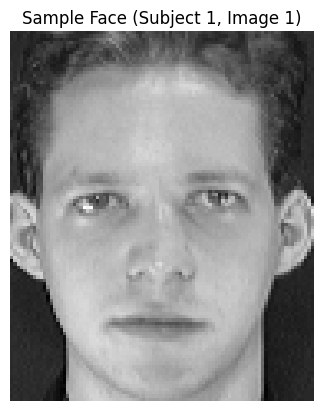

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Example: Load the first image of the first subject
sample_img_path = os.path.join(extract_dir, "s1", "1.pgm")
img = mpimg.imread(sample_img_path)

# Display the image
plt.imshow(img, cmap='gray')
plt.title("Sample Face (Subject 1, Image 1)")
plt.axis('off')
plt.show()

In [27]:
from PIL import Image
import os

# Path to an example image (adjust as needed)
image_path = "att_faces/s1/1.pgm"  # Example path

# Open the image
img = Image.open(image_path)

# Get image size (width, height)
width, height = img.size

print(f"Image dimensions (width x height): {width} x {height}")
print(f"Total pixels: {width * height}")

Image dimensions (width x height): 92 x 112
Total pixels: 10304


In [28]:
import os
import numpy as np
from PIL import Image

# Initialize empty matrix (400 images x 10304 pixels)
data_matrix = np.zeros((400, 10304))  # 400 samples, 10304 features per image
row_index = 0

# Path to the extracted dataset (adjust if needed)
dataset_path = "att_faces"

# Loop through all subjects (s1 to s40)
for subject in range(1, 41):
    subject_dir = os.path.join(dataset_path, f"s{subject}")

    # Loop through all images (1.pgm to 10.pgm)
    for img_num in range(1, 11):
        img_path = os.path.join(subject_dir, f"{img_num}.pgm")

        # Open image, convert to numpy array, and flatten
        img = Image.open(img_path)
        img_array = np.array(img).flatten()  # Shape: (10304,)

        # Add to data_matrix
        data_matrix[row_index, :] = img_array
        row_index += 1

print("Data matrix shape:", data_matrix.shape)

Data matrix shape: (400, 10304)


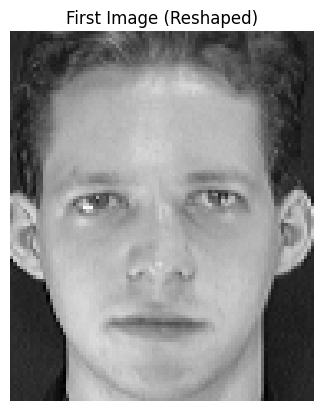

In [29]:
# Reshape the first row back to 92x112 and display
sample_image = data_matrix[0, :].reshape(112, 92)  # Note: PGM is height x width

import matplotlib.pyplot as plt
plt.imshow(sample_image, cmap='gray')
plt.title("First Image (Reshaped)")
plt.axis('off')
plt.show()

In [30]:
import numpy as np

# Initialize the label vector (400 samples)
y = np.zeros(400, dtype=int)  # Use dtype=int for class labels

# Assign labels: 1 to 40, repeated 10 times each
for subject in range(40):
    y[subject * 10 : (subject + 1) * 10] = subject + 1  # Labels start at 1

print("Label vector shape:", y.shape)
print("First 15 labels:", y[:15])  # Check the first 15 labels

Label vector shape: (400,)
First 15 labels: [1 1 1 1 1 1 1 1 1 1 2 2 2 2 2]


In [31]:
import numpy as np

# Assuming:
# X = data_matrix (400x10304)
# y = label vector (400,)
X = data_matrix
# Get all odd indices (1st, 3rd, 5th, ... rows) --> Training
X_train = X[::2, :]   # Start at 0, step by 2 (0, 2, 4, ...)
y_train = y[::2]

# Get all even indices (2nd, 4th, 6th, ... rows) --> Testing
X_test = X[1::2, :]   # Start at 1, step by 2 (1, 3, 5, ...)
y_test = y[1::2]

# Verify shapes
print("Training data shape:", X_train.shape)  # Expected: (200, 10304)
print("Testing data shape:", X_test.shape)    # Expected: (200, 10304)
print("Training labels shape:", y_train.shape)  # Expected: (200,)
print("Testing labels shape:", y_test.shape)    # Expected: (200,)

Training data shape: (200, 10304)
Testing data shape: (200, 10304)
Training labels shape: (200,)
Testing labels shape: (200,)


In [32]:
import numpy as np

X = data_matrix

X_train = X[::2, :]   # Start at 0, step by 2 (0, 2, 4, ...)
y_train = y[::2]

X_test = X[1::2, :]   # Start at 1, step by 2 (1, 3, 5, ...)
y_test = y[1::2]

In [33]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin

class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-4):
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol

    def _initialize_params(self, X):
        self.N, self.M = X.shape

        # K-means initialization
        kmeans = KMeans(n_clusters=self.K, n_init=5).fit(X)
        self.means = kmeans.cluster_centers_

        # Initialize responsibilities
        self.r = np.zeros((self.N, self.K))
        self.r[np.arange(self.N), kmeans.labels_] = 1

        # Initialize mixing coefficients
        self.weights = np.bincount(kmeans.labels_, minlength=self.K) / self.N

        # Initialize diagonal covariances
        self.covs = np.zeros((self.K, self.M))
        for k in range(self.K):
            cluster_data = X[kmeans.labels_ == k]
            if len(cluster_data) > 1:
                self.covs[k] = np.var(cluster_data, axis=0)
            else:
                self.covs[k] = np.ones(self.M)
            self.covs[k] += 1e-6  # Regularization

    def _expectation_step(self, X):
        log_prob = np.zeros((self.N, self.K))

        for k in range(self.K):
            try:
                # Create diagonal covariance matrix
                cov_matrix = np.diag(self.covs[k])
                rv = multivariate_normal(self.means[k], cov_matrix, allow_singular=True)
                log_prob[:, k] = np.log(self.weights[k] + 1e-10) + rv.logpdf(X)
            except:
                log_prob[:, k] = -np.inf

        # Log-sum-exp trick
        log_r = log_prob - logsumexp(log_prob, axis=1, keepdims=True)
        self.r = np.exp(log_r)

    def _maximization_step(self, X):
        Nk = np.sum(self.r, axis=0)

        # Update weights
        self.weights = Nk / self.N

        # Update means
        self.means = (self.r.T @ X) / Nk[:, None]

        # Update diagonal covariances
        for k in range(self.K):
            diff = X - self.means[k]
            self.covs[k] = np.sum(self.r[:, k, None] * (diff ** 2), axis=0) / Nk[k]
            self.covs[k] += 1e-6  # Regularization

    def _compute_log_likelihood(self, X):
        log_prob = np.zeros((self.N, self.K))
        for k in range(self.K):
            try:
                cov_matrix = np.diag(self.covs[k])
                rv = multivariate_normal(self.means[k], cov_matrix, allow_singular=True)
                log_prob[:, k] = np.log(self.weights[k] + 1e-10) + rv.logpdf(X)
            except:
                log_prob[:, k] = -np.inf
        return np.sum(logsumexp(log_prob, axis=1))

    def fit(self, X, y_train):
        self._initialize_params(X)
        prev_ll = -np.inf

        for i in range(self.max_iter):
            self._expectation_step(X)
            self._maximization_step(X)

            current_ll = self._compute_log_likelihood(X)
            if np.abs(current_ll - prev_ll) < self.tol:
                break
            prev_ll = current_ll

        self._create_cluster_map(X, y_train)
        return self

    def _create_cluster_map(self, X, y):
        clusters = self.predict(X)
        self.cluster_map_ = {}

        for k in range(self.K):
            mask = (clusters == k)
            if np.any(mask):
                self.cluster_map_[k] = np.argmax(np.bincount(y[mask]))
            else:
                self.cluster_map_[k] = 0
        return self

    def predict_proba(self, X):

        log_prob = np.zeros((X.shape[0], self.K))
        for k in range(self.K):
            try:
                cov_matrix = np.diag(self.covs[k])
                rv = multivariate_normal(self.means[k], cov_matrix, allow_singular=True)
                log_prob[:, k] = np.log(self.weights[k] + 1e-10) + rv.logpdf(X)
            except:
                log_prob[:, k] = -np.inf

        log_prob -= logsumexp(log_prob, axis=1, keepdims=True)
        return np.exp(log_prob)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y):
        y_pred = np.array([self.cluster_map_[c] for c in self.predict(X)])
        return accuracy_score(y, y_pred)

# Main execution with parameter grid
if __name__ == "__main__":

    K_values = [20, 40, 60]
    alpha_values = [0.8, 0.85, 0.9, 0.95]

    results = []

    for K in K_values:
        for alpha in alpha_values:
            print(f"\n{'='*50}")
            print(f"Training GMM with K={K}, α={alpha}")
            print(f"{'='*50}")

            # Apply PCA
            pca = PCA(alpha=alpha)
            X_train_pca = pca.fit_transform(X_train)
            X_test_pca = pca.transform(X_test)

            # Train GMM
            gmm = GMM(n_components=K)
            gmm.fit(X_train_pca, y_train)

            test_acc = gmm.score(X_test_pca, y_test)
            y_pred_test = np.array([gmm.cluster_map_[c] for c in gmm.predict(X_test_pca)])

            # Calculate metrics
            f1_test = f1_score(y_test, y_pred_test, average='weighted')
            cm_test = confusion_matrix(y_test, y_pred_test)

            # Print results
            print(f"\nMetrics:")
            print(f"Test Accuracy: {test_acc:.4f}")
            print(f"Test F1: {f1_test:.4f}")
            print("\nTest Confusion Matrix:")
            print(cm_test)


Training GMM with K=20, α=0.8

Metrics:
Test Accuracy: 0.3950
Test F1: 0.2864

Test Confusion Matrix:
[[4 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Training GMM with K=20, α=0.85

Metrics:
Test Accuracy: 0.4200
Test F1: 0.3011

Test Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Training GMM with K=20, α=0.9

Metrics:
Test Accuracy: 0.3850
Test F1: 0.2770

Test Confusion Matrix:
[[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 1 ... 3 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Training GMM with K=20, α=0.95

Metrics:
Test Accuracy: 0.3850
Test F1: 0.2593

Test Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Training GMM with K=40, α=0.8

Metrics:
Test Accuracy: 0.6700
Test F1: 0.6486

Test Confusion Matrix:
[[4

In [34]:
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class Autoencoder(nn.Module):
    def __init__(self, input_dim=10304, latent_dim=100):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Assuming images are normalized
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent
# Convert the data into torch tensors
X_train_tensor = torch.FloatTensor(X_train) / 255.0  # Normalize (important!)
X_test_tensor = torch.FloatTensor(X_test) / 255.0

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



## train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder(input_dim=10304, latent_dim=100).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

n_epochs = 50
autoencoder.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    for batch in train_loader:
        inputs = batch[0].to(device)

        optimizer.zero_grad()
        outputs, _ = autoencoder(inputs)

        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.6f}")

Epoch 1/50, Loss: 0.033769
Epoch 2/50, Loss: 0.024886
Epoch 3/50, Loss: 0.024532
Epoch 4/50, Loss: 0.023111
Epoch 5/50, Loss: 0.022491
Epoch 6/50, Loss: 0.020722
Epoch 7/50, Loss: 0.019502
Epoch 8/50, Loss: 0.019262
Epoch 9/50, Loss: 0.019098
Epoch 10/50, Loss: 0.018439
Epoch 11/50, Loss: 0.017910
Epoch 12/50, Loss: 0.016886
Epoch 13/50, Loss: 0.016535
Epoch 14/50, Loss: 0.016420
Epoch 15/50, Loss: 0.015514
Epoch 16/50, Loss: 0.015141
Epoch 17/50, Loss: 0.014535
Epoch 18/50, Loss: 0.014121
Epoch 19/50, Loss: 0.013890
Epoch 20/50, Loss: 0.013178
Epoch 21/50, Loss: 0.012993
Epoch 22/50, Loss: 0.012758
Epoch 23/50, Loss: 0.012186
Epoch 24/50, Loss: 0.011997
Epoch 25/50, Loss: 0.011982
Epoch 26/50, Loss: 0.011795
Epoch 27/50, Loss: 0.011179
Epoch 28/50, Loss: 0.011056
Epoch 29/50, Loss: 0.011170
Epoch 30/50, Loss: 0.011219
Epoch 31/50, Loss: 0.010947
Epoch 32/50, Loss: 0.010627
Epoch 33/50, Loss: 0.010421
Epoch 34/50, Loss: 0.010452
Epoch 35/50, Loss: 0.010380
Epoch 36/50, Loss: 0.010102
E

In [35]:
autoencoder.eval()
with torch.no_grad():
    _, X_train_latent = autoencoder(X_train_tensor.to(device))
    _, X_test_latent = autoencoder(X_test_tensor.to(device))

# Move to CPU and convert to numpy
X_train_latent = X_train_latent.cpu().numpy()
X_test_latent = X_test_latent.cpu().numpy()

autoencoder.eval()
with torch.no_grad():
    _, X_train_latent = autoencoder(X_train_tensor.to(device))
    _, X_test_latent = autoencoder(X_test_tensor.to(device))

# Move to CPU and convert to numpy
X_train_latent = X_train_latent.cpu().numpy()
X_test_latent = X_test_latent.cpu().numpy()

In [37]:
for K in K_values:
      print(f"\n{'='*50}")
      print(f"Training GMM with K={K}")
      print(f"{'='*50}")

      # Train GMM
      gmm = GMM(n_components=K)
      gmm.fit(X_train_latent, y_train)

      # Evaluate
      test_acc = gmm.score(X_test_latent, y_test)

      # Get predictions
      y_pred_test = np.array([gmm.cluster_map_[c] for c in gmm.predict(X_test_latent)])

      # Calculate metrics
      f1_test = f1_score(y_test, y_pred_test, average='weighted')
      cm_test = confusion_matrix(y_test, y_pred_test)

      # Print results
      print(f"\nMetrics:")
      print(f"Test Accuracy: {test_acc:.4f}")
      print(f"Test F1: {f1_test:.4f}")

      print("\nTest Confusion Matrix:")
      print(cm_test)


Training GMM with K=20

Metrics:
Test Accuracy: 0.4050
Test F1: 0.2873

Test Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]]

Training GMM with K=40

Metrics:
Test Accuracy: 0.5150
Test F1: 0.4802

Test Confusion Matrix:
[[0 1 0 ... 0 0 2]
 [0 5 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 3]]

Training GMM with K=60

Metrics:
Test Accuracy: 0.5000
Test F1: 0.4456

Test Confusion Matrix:
[[0 3 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 0]]


In [22]:
class PCA:
    def __init__(self, n_components=None, alpha=None):
        """
        Parameters:
        - n_components: int, number of components to keep
        - alpha: float (0-1), minimum variance ratio to retain
        """
        self.n_components = n_components
        self.alpha = alpha
        self.components = None
        self.mean = None
        self.explained_variance_ratio = None

    def fit(self, X):
        # 1. Standardize the data (center to mean)
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Save/load eigenvalues and eigenvectors
        if os.path.exists('eigenvalues.npy') and os.path.exists('eigenvectors.npy'):
            self.eigenvalues = np.load('eigenvalues.npy')
            self.eigenvectors = np.load('eigenvectors.npy')
        else:
            cov_matrix = np.cov(X_centered, rowvar=False)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
            sorted_indices = np.argsort(eigenvalues)[::-1]
            self.eigenvalues = eigenvalues[sorted_indices]
            self.eigenvectors = eigenvectors[:, sorted_indices]

            np.save('eigenvalues.npy', self.eigenvalues)
            np.save('eigenvectors.npy', self.eigenvectors)

        # 5. Compute explained variance ratio ??
        total_variance = np.sum(self.eigenvalues)
        self.explained_variance_ratio = self.eigenvalues / total_variance

        # 6. Determine number of components to keep
        if self.alpha is not None:
            cumulative_variance = np.cumsum(self.explained_variance_ratio)
            self.n_components = np.argmax(cumulative_variance >= self.alpha) + 1

        # 7. Select top components with max eigenvalue
        self.components = self.eigenvectors[:, :self.n_components] ## using in inverse transform

        return self

    def transform(self, X):
        # Center the data using the mean from training
        X_centered = X - self.mean

        # Project data onto principal components
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [23]:
def apply_pca(X_train, X_test, alpha=0.9): ## default with 99%
    """"
    make a pojection for x_test  not need to fit but train must fit then make a projuction
    make a fit transform for x_train

    """
    pca = PCA(alpha=alpha)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca

# Apply PCA with different thresholds
alphas = [0.8, 0.85, 0.9, 0.95] ## the information needed to keep from pca taining
pca_results = {}

for alpha in alphas:
    X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test, alpha)
    pca_results[alpha] = {
        'train': X_train_pca,
        'test': X_test_pca,
        'pca': pca,
        'n_components': pca.n_components,  # Fixed: no underscore
        'explained_variance': pca.explained_variance_ratio  # Fixed: no underscore
    }
    print(f"Alpha: {alpha}, Components: {pca.n_components}, Explained Variance: {np.sum(pca.explained_variance_ratio):.4f}")

Alpha: 0.8, Components: 36, Explained Variance: 1.0000
Alpha: 0.85, Components: 51, Explained Variance: 1.0000
Alpha: 0.9, Components: 76, Explained Variance: 1.0000
Alpha: 0.95, Components: 115, Explained Variance: 1.0000
